In [1]:
%%configure -f
{"name": "arik-query-logcube-x", "executorMemory": "8G", "numExecutors": 16, "executorCores": 4,
 "conf": {"spark.yarn.appMasterEnv.PYSPARK_PYTHON":"python3"}}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
41,application_1586890731024_0038,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
data = spark.read.parquet('hdfs:///manga/arik-test/dr15/v2_4_3/logcube')
data.createOrReplaceTempView('cube')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
t = time.time()
spark.sql('''SELECT count(*) FROM cube''').show()
print(time.time() - t)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|10179808|
+--------+

18.807895183563232

In [5]:
mangaids = spark.sql('''SELECT distinct(mangaid) mangaid FROM cube LIMIT 10''').toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
t = time.time()
top10objects = data.filter(data.MANGAID.isin(list(mangaids['mangaid']))).\
    select('MANGAID', '_SRC_X', '_SRC_Y', 'G').toPandas()
print(time.time() - t)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10.002555131912231

In [7]:
def reconstruct_g_img(data, mangaid):
    d = data[data['MANGAID'] == mangaid]
    shape = (d['_SRC_Y'].max()+1, d['_SRC_X'].max()+1)
    img = np.zeros(shape)
    img[d['_SRC_Y'], d['_SRC_X']] = d['G']
    return img

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
fig, axs = plt.subplots(2, 5, figsize=[22,8])
for ax, mangaid in zip(axs.ravel(), mangaids['mangaid']):
    _ = ax.imshow(reconstruct_g_img(top10objects, mangaid), aspect='auto')
_ = plt.subplots_adjust(left=0.01, right=0.99)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

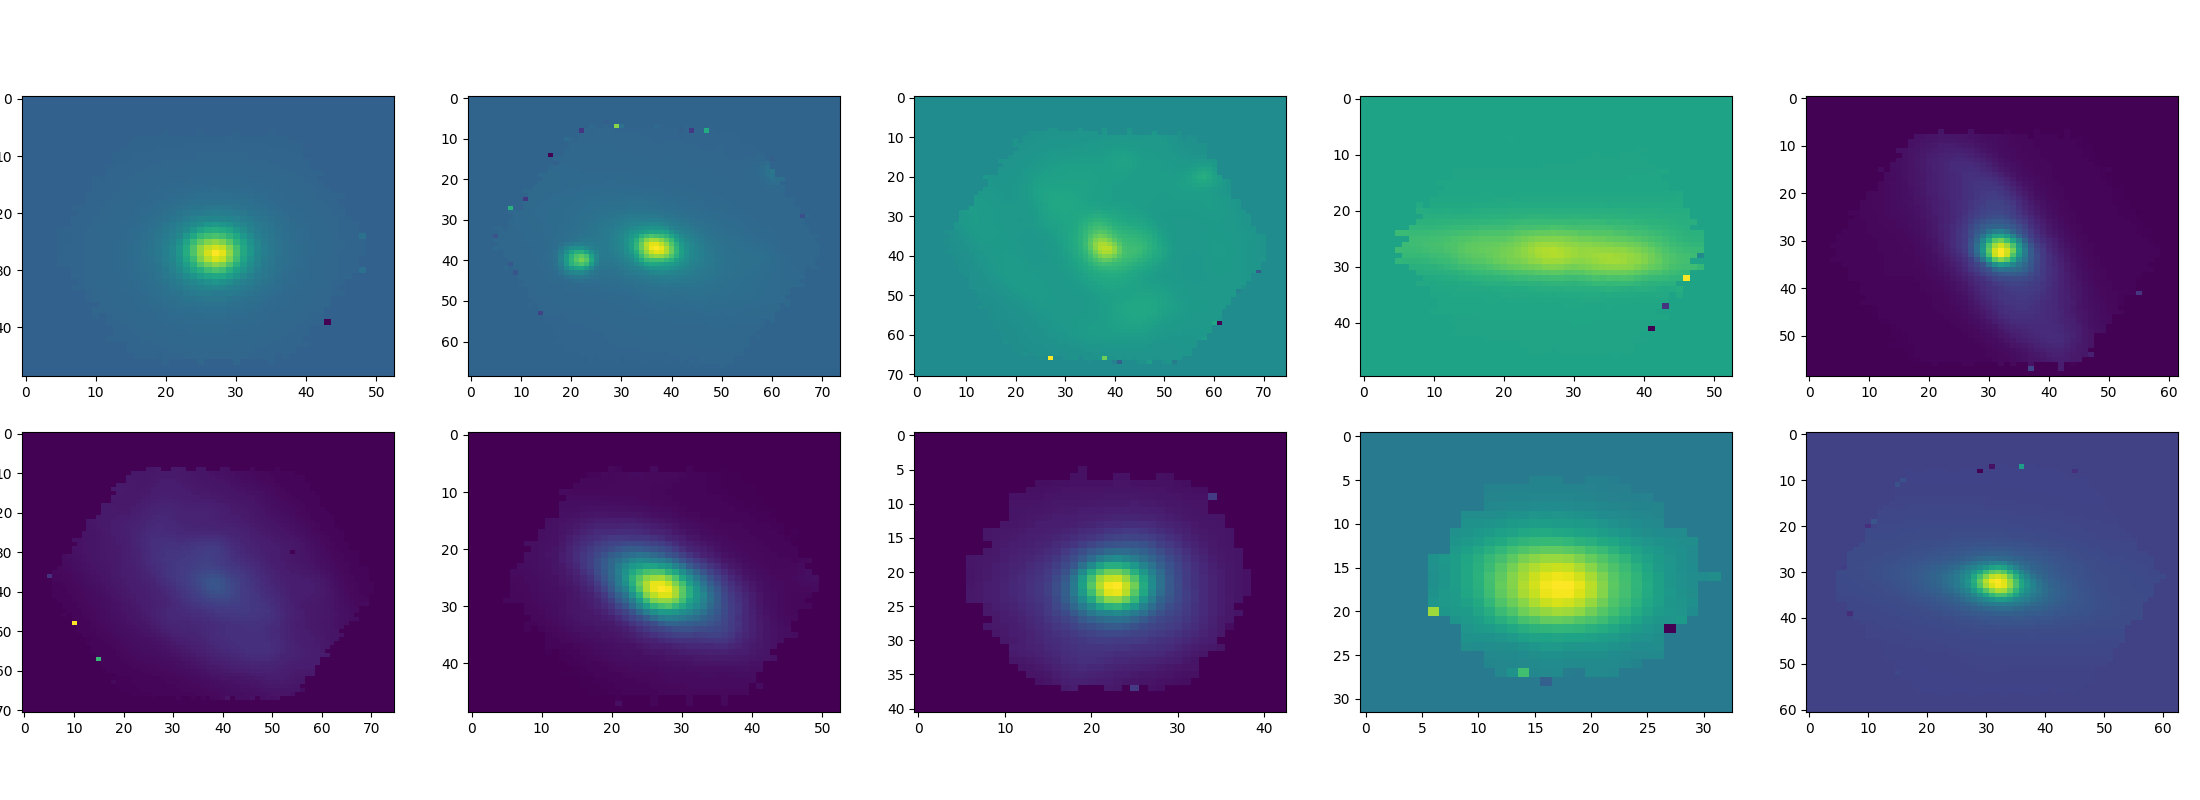

In [9]:
%matplot plt

Get the sum of flux across the whole sky. Here we sum the flux along each spaxel and also bin by RA/DEC integral degrees, summing the flux of spaxels in that integral degree range.

In [12]:
t = time.time()
flux_ra_dec = spark.sql('''
SELECT RA, DEC, sum(TOT_FLUX) FLUX
FROM (
  SELECT CAST(RA as INT), CAST(DEC as INT), aggregate(FLUX, double(0.0), (a, x) -> a+x) as TOT_FLUX FROM cube
 )
GROUP BY RA, DEC
''').toPandas()
print(time.time() - t)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

250.08500623703003

In [76]:
f = plt.figure(figsize=[12,6])
ax = f.add_subplot(111, projection='mollweide')
ra_ = flux_ra_dec['RA']/180*np.pi - np.pi
dec_ = flux_ra_dec['DEC']/90*np.pi/2
plt.set_cmap('hsv')
plt.grid(True)
ax.set_title('All sky total flux')
ax.hexbin(ra_, dec_, C=np.log(flux_ra_dec['FLUX']+0.001))
_ = plt.subplots_adjust(left=0.01, right=0.99, top=0.90)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

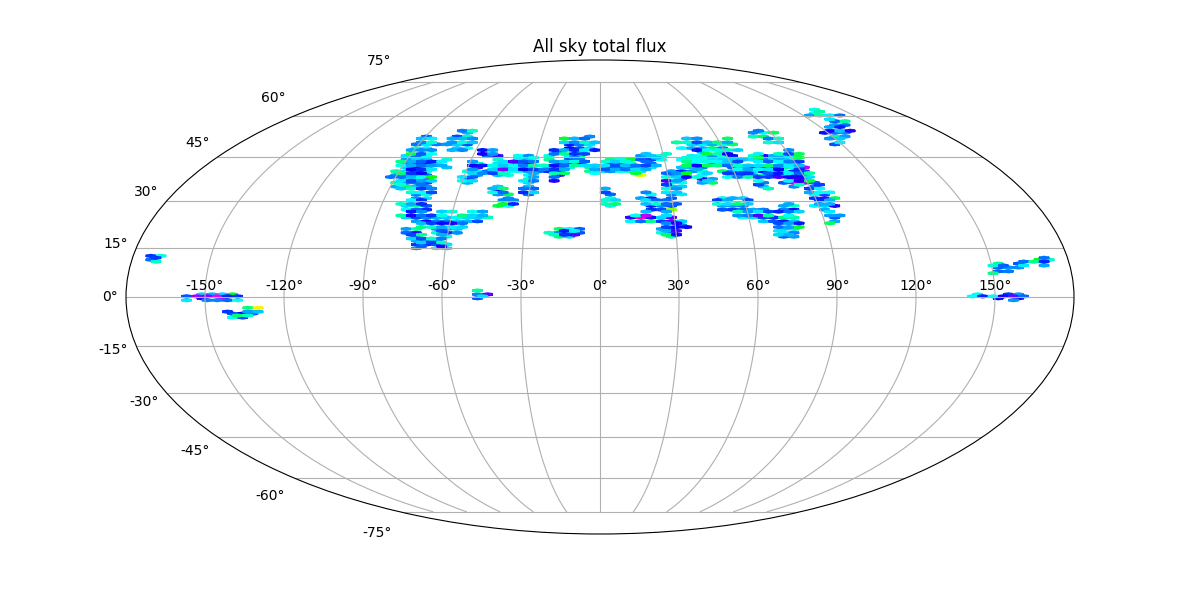

In [77]:
%matplot plt